### Import Libraries

In [1]:
import os
import cv2
import math
import time
import tarfile
import numbers
import threading
import queue as Queue
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
#from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, DataLoader, Dataset
from torchsummary import summary

In [2]:
import mxnet as mx
from mxnet import recordio

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
random_seed = 42
torch.manual_seed(random_seed);

In [5]:
torch.set_printoptions(edgeitems=5)

In [6]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True) #, dtype=torch.float

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [7]:
device = get_default_device()

In [8]:
device

device(type='cuda')

In [9]:
#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

<b>Steps:</b>

    1. Dataset:
        a) Fetch/Download the Image dataset
        b) Visualize the dataset
        c) Preprocessing:
            i) Split dataset
            ii) Image augmentation
            iii) Data generator
    2. Model Architecture
        a) Network
        b) Loss Function
    3. Train model
    4. Evaluate model
        a) Plot Loss and Accuracy curves
    5. Visualize/Predict results on test sets

### Step 1a) Fetch the MS1M-ArcFace dataset

In [10]:
class ArcFaceDataset(Dataset):
    def __init__(self, root_dir):
        super(ArcFaceDataset, self).__init__()

        self.transform = transforms.Compose(
            [transforms.ToPILImage(),
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
             ])
        
        self.root_dir = root_dir
        #root_dir2 = "D:/Face/faces_emore/" #"faces_emore/"
        
        path_imgrec = os.path.join(root_dir, 'train.rec')
        path_imgidx = os.path.join(root_dir, 'train.idx')
        self.imgrec = mx.recordio.MXIndexedRecordIO(path_imgidx, path_imgrec, 'r')
        s = self.imgrec.read_idx(0)
        header, _ = mx.recordio.unpack(s)
        
        if header.flag > 0:
            self.header0 = (int(header.label[0]), int(header.label[1]))
            self.imgidx = np.array(range(1, int(header.label[0])))
        else:
            self.imgidx = np.array(list(self.imgrec.keys)) #List of numbers 1 .... 5908396

    def __getitem__(self, index):
        idx = self.imgidx[index]
        s = self.imgrec.read_idx(idx)
        header, img = mx.recordio.unpack(s)
        label = header.label
        if not isinstance(label, numbers.Number):
            label = label[0]
        label = torch.tensor(label, dtype=torch.long)
        sample = mx.image.imdecode(img).asnumpy()
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, label

    def __len__(self):
        return len(self.imgidx)

In [11]:
root_dir1 = "faces_emore/" #For Ubuntu
root_dir2 = "D:/Face/faces_emore/" #For Windows

dataset = ArcFaceDataset(root_dir1)

In [12]:
dataset

In [13]:
len(dataset)

5822653

In [14]:
# d_test = dataset[5:]

### Step 1b) Visualize the dataset

In [15]:
img, label = dataset[0]
print(img.shape, label)

img = torch.reshape(img, (112, 112, 3))
print(img.shape)

torch.Size([3, 112, 112]) tensor(0)
torch.Size([112, 112, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'label = 0')

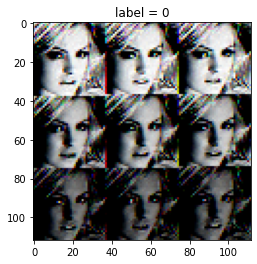

In [16]:
plt.imshow(img)
plt.title('label = ' + str(label.item()))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'label = 85741')

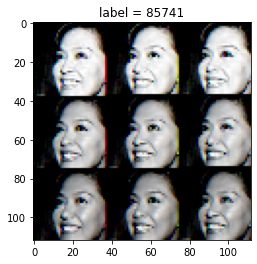

In [17]:
img, label = dataset[5822652]
img = torch.reshape(img, (112, 112, 3))

plt.imshow(img)
plt.title('label = ' + str(label.item()))

### Step 1c) Split the dataset into training, validation, and testing

In [18]:
#Limiting the dataset for computation purposes

lim_factor = 1 #Set to 1 for using the entire dataset
lim_size = int(lim_factor * len(dataset))
lim_dataset_size = len(dataset) - lim_size

large_ds, lim_ds = random_split(dataset, [lim_dataset_size, lim_size])

In [19]:
len(large_ds), len(lim_ds)

(0, 5822653)

In [20]:
test_factor = 0.1
test_size = int(test_factor * len(lim_ds))
train_size = len(lim_ds) - test_size
train_ds, test_ds = random_split(lim_ds, [train_size, test_size])

val_factor = 0.1
val_size = int(val_factor * len(lim_ds))
train_size = len(train_ds) - val_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size])

In [21]:
len(train_ds), len(val_ds), len(test_ds)

(4658123, 582265, 582265)

In [22]:
batch_size=128

In [23]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, num_workers=4, pin_memory=True)

In [24]:
train_dl

In [25]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [26]:
len(train_dl), len(val_dl), len(test_dl)

(36392, 4549, 4549)

### Step 2a) Model Architecture - Network

In [27]:
def conv_2d(ni, nf, ks, stride=1):
    return nn.Conv2d(in_channels=ni, out_channels=nf, kernel_size=ks, stride=stride, padding=ks//2, bias=False)

def bn_relu_conv(ni, nf, ks):
    return nn.Sequential(nn.BatchNorm2d(ni), 
                       nn.ReLU(inplace=True),
                       conv_2d(ni, nf, ks))

In [28]:
class ResBlock(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        if ni > 100:
            temp = ni * 2
        else:
            temp = ni
        self.bn = nn.BatchNorm2d(temp)
        self.conv1 = conv_2d(temp, ni, 1, stride)
        self.conv2 = bn_relu_conv(ni, ni, ks=3)
        self.conv3 = bn_relu_conv(ni, nf, ks=1)
        self.shortcut = lambda x: x
        if ni != nf:
            self.shortcut = conv_2d(temp, nf, 1, stride)

    def forward(self, x):
        #print("Inside Res Block1")
        #print(x.shape)
        x = F.relu(self.bn(x), inplace=True)
        #print(x.shape)
        r1 = self.shortcut(x)
        #print(r1.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x) * 0.2
        #print(x.shape)
        return x.add_(r1)

In [29]:
class ResBlock2(nn.Module):
    def __init__(self, ni, nf, stride=1):
        super().__init__()
        self.bn = nn.BatchNorm2d(ni)
        self.conv1 = conv_2d(ni, nf, 1, stride)
        self.conv2 = bn_relu_conv(nf, nf, ks=3)
        self.conv3 = bn_relu_conv(nf, ni, ks=1)
        self.shortcut = lambda x: x
#        if ni != nf:
#            self.shortcut = conv_2d(ni, nf, 1, 1)

    def forward(self, x):
        #print("Inside Res Block2")
        #print(x.shape)
        x = F.relu(self.bn(x), inplace=True)
        #print(x.shape)
        r = self.shortcut(x)
        #print(r.shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x) * 0.2
        return x.add_(r)

In [30]:
def make_group(N, ni, nf, stride):
    start = ResBlock(ni, nf, stride)
    rest = [ResBlock2(nf, ni) for j in range(1, N)]
    return [start] + rest

In [31]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return x.view(x.size(0), -1)

In [32]:
# class MyResNet(nn.Module):
#     def __init__(self, n_groups, N, n_classes, k=1, n_start=64):
#         super().__init__()
#         #Increase channels
#         layers = [conv_2d(3, 64, ks=7, stride=2)]
#         layers += [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]
#         n_channels = [n_start]

#         #Add groups
#         for i in range(n_groups):
#             n_channels.append(n_start*(2**i)*k)
#             stride = 2 if i>0 else 1
#             layers += make_group(N[i], n_channels[i], n_channels[i]*4, stride)

#         #Pool, Flatten, and add linear layer for classification  
#         layers += [nn.BatchNorm2d(n_channels[n_groups]*2),
#                    nn.ReLU(inplace=True),
#                    nn.AdaptiveAvgPool2d(1),
#                    #nn.AvgPool2d(kernel_size=2, stride=2), 
#                    Flatten(), 
#                    nn.Linear(n_channels[n_groups]*2, n_classes)]
    
#         self.features = nn.Sequential(*layers)
        
#     def forward(self, x):
#         #a = self.features(x)
#         #print(a.shape)
#         return self.features(x)

In [33]:
class MyResNet(nn.Module):
    def __init__(self, n_groups, N, n_classes, k=1, n_start=64):
        super().__init__()
        #Increase channels
        self.layers = [conv_2d(3, 64, ks=7, stride=2)]
        self.layers += [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]
        n_channels = [n_start]

        #Add groups
        for i in range(n_groups):
            n_channels.append(n_start*(2**i)*k)
            stride = 2 if i>0 else 1
            self.layers += make_group(N[i], n_channels[i], n_channels[i]*4, stride)

        #Pool, Flatten, and add linear layer for classification  
        self.layers += [nn.BatchNorm2d(n_channels[n_groups]*2),
                   nn.ReLU(inplace=True),
                   nn.AdaptiveAvgPool2d(1),
                   #nn.AvgPool2d(kernel_size=2, stride=2), 
                   Flatten()]
        #self.fc = nn.Linear(n_channels[n_groups]*2, n_classes)
    
        self.features = nn.Sequential(*self.layers)
        
    def forward(self, x):
        #a = self.features(x)
        #print(a.shape)
        temp = self.features(x)
        return temp #self.fc(temp)

In [34]:
#Number of blocks at various groups
N_50 = [3, 4, 6, 3]
N_101 = [3, 4, 23, 3]
N_152 = [3, 8, 36, 3]

def ResNet50(n_classes):
    return MyResNet(4, N_50, n_classes, k=2)

def ResNet101(n_classes):
    return MyResNet(4, N_101, n_classes, k=2)

def ResNet152(n_classes):
    return MyResNet(4, N_152, n_classes, k=2)

In [35]:
# test_model = ResNet50(10)

In [36]:
# test_model

In [37]:
# def test():
#     net = ResNet50(10)
#     x = torch.randn(2, 3, 112, 300)
#     y = net(x)
#     print(y.shape)

In [38]:
# test()

In [39]:
# class ResNet_WIP(nn.Module):
#     def __init__(self, n_groups, N, n_classes, k=1, n_start=64):
#         super().__init__()
#         #Increase channels
#         self.layers = [conv_2d(3, 64, ks=7, stride=2)]
#         self.layers += [nn.MaxPool2d(kernel_size=3, stride=2, padding=1)]
#         n_channels = [n_start]

#         #Add groups
#         for i in range(n_groups):
#             n_channels.append(n_start*(2**i)*k)
#             stride = 2 if i>0 else 1
#             self.layers += self.make_group(N[i], n_channels[i], n_channels[i]*4, stride)

#         #Pool, Flatten, and add linear layer for classification  
#         self.layers += [nn.BatchNorm2d(n_channels[n_groups]*2),
#                    nn.ReLU(inplace=True),
#                    nn.AdaptiveAvgPool2d(1),
#                    #nn.AvgPool2d(kernel_size=2, stride=2), 
#                    Flatten(), 
#                    nn.Linear(n_channels[n_groups]*2, n_classes)]
#                    #nn.Softmax(dim=1)]
    
#         self.features = nn.Sequential(*self.layers)
        
#     def forward(self, x):
#         return self.features(x)

#     def make_group(self, N, ni, nf, stride):
#         start = ResBlock(ni, nf, stride)
#         rest = [ResBlock2(nf, ni) for j in range(1, N)]
#         return [start] + rest

In [40]:
model = ResNet50(85742)

In [42]:
to_device(model, device)

MyResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): ResBlock(
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv3): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (shortcut): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (3): ResBlock2(
      (bn): 

In [43]:
summary(model, input_size = (3, 112, 112), batch_size = -1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]           9,408
         MaxPool2d-2           [-1, 64, 28, 28]               0
       BatchNorm2d-3           [-1, 64, 28, 28]             128
            Conv2d-4          [-1, 256, 28, 28]          16,384
            Conv2d-5           [-1, 64, 28, 28]           4,096
       BatchNorm2d-6           [-1, 64, 28, 28]             128
              ReLU-7           [-1, 64, 28, 28]               0
            Conv2d-8           [-1, 64, 28, 28]          36,864
       BatchNorm2d-9           [-1, 64, 28, 28]             128
             ReLU-10           [-1, 64, 28, 28]               0
           Conv2d-11          [-1, 256, 28, 28]          16,384
         ResBlock-12          [-1, 256, 28, 28]               0
      BatchNorm2d-13          [-1, 256, 28, 28]             512
           Conv2d-14           [-1, 64,

In [44]:
# for images, labels in test_dl:
#     #print("Inside")
#     print('images.shape:', images.shape)
#     print('labels.shape:', labels.shape)
#     print('labels:', labels)
#     out = model(images)
#     print('out.shape:', out.shape)
#     print('out[0]:', out[0])
#     print('out[0].shape:', out[0].shape)
    
#     pre_sum = torch.sum(out, dim=1) #torch.sum(out[0], dim=0)
#     print('sum of out[0]:', pre_sum.shape)
    
#     F_sum = torch.sum(F.softmax(out, dim=1), dim=1)
#     print('softmax of out[0]:', F_sum.shape)
#     break

In [45]:
#loaded_model.load_state_dict(torch.load("training/el_2epoch_70acc.pth"))
model.load_state_dict(torch.load("training/el_22epoch_95acc_cosface.pth"))

<All keys matched successfully>

In [46]:
to_device(model, device)

MyResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (2): ResBlock(
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (conv3): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (shortcut): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (3): ResBlock2(
      (bn): 

### Step 2b) Loss Function

In [47]:
class CosFace(nn.Module):
    def __init__(self, in_features=2048, out_features=85742, s=64.0, m=0.35):
        super(CosFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.kernel = nn.Parameter(torch.FloatTensor(in_features, out_features))
        nn.init.normal_(self.kernel, std=0.01)

    def forward(self, logits, labels):
        logits = F.normalize(logits, p=2.0, dim=1) #l2_norm(logits, axis=1)
        kernel_norm = F.normalize(self.kernel, p=2.0, dim=0) #l2_norm(self.kernel, axis=0)
        cos_theta = torch.mm(logits, kernel_norm)
        cos_theta = cos_theta.clamp(-1, 1)  # for numerical stability
        index = torch.where(labels != -1)[0]
        m_hot = torch.zeros(index.size()[0], cos_theta.size()[1]).to(device)
        m_hot.scatter_(1, labels[index, None], self.m).to(device)
        cos_theta[index] -= m_hot
        ret = cos_theta * self.s
        return ret

In [48]:
# class CosFace(torch.nn.Module):
#     def __init__(self, s=64.0, m=0.35):
#         super(CosFace, self).__init__()
#         self.s = s
#         self.m = m

#     def forward(self, logits, labels):
#         index = torch.where(labels != -1)[0]
#         target_logit = logits[index, labels[index].view(-1)]
#         final_target_logit = target_logit - self.m
#         logits[index, labels[index].view(-1)] = final_target_logit
#         logits = logits * self.s
#         return logits

In [49]:
new_logits = CosFace()

In [50]:
to_device(new_logits, device)
#new_logits.to(device)

CosFace()

In [48]:
loss_Function = F.cross_entropy #CosFace() #

### Step 3) Training the model

In [49]:
def loss_batch(model, loss_func, xb, yb, opt=None, opt_out=None, metric=None):
    #Generate predictions
    features = F.normalize(model(xb))
    preds = new_logits(features, yb)
    
    #Generate probabilities
    #preds = F.softmax(preds, dim=1)
    
    #Calculate loss
    loss = loss_func(preds, yb)
    
    if opt is not None:
        #Compute gradients
        loss.backward()
        
        #Gradient Clipping
        #nn.utils.clip_grad_norm_(model.parameters(), max_norm=5, norm_type=2)
        
        #update parameters
        opt.step()
        opt_out.step()
        
        #Reset Gradients
        opt.zero_grad()
        opt_out.zero_grad()

    metric_result = None
    if metric is not None:
        #compute the metric
        metric_result = metric(preds, yb)
    
    #print(loss.is_cuda)
    #print(xb.is_cuda)
    #print(metric_result.is_cuda)
        
    return loss.item(), len(xb), metric_result

In [50]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        #pass each batch through the model
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric) for xb, yb in valid_dl]
        #separate losses, counts and metrics
        losses, nums, metrics = zip(*results)
        #Total size of the dataset
        total = np.sum(nums)
        #Avg. loss across batches
        avg_loss = np.sum(np.multiply(losses, nums))/total
        avg_metric = None
        
        if metric is not None:
            #Avg of metric across batches
            avg_metric = np.sum(np.multiply(metrics, nums)) / total

    return avg_loss, total, avg_metric

In [51]:
def fit(epochs, model, loss_fn, train_dl, valid_dl, lr=None, metric=None, opt_fn=None):
    
    train_losses, val_losses, val_metrics = [], [], []
    
    #instantiate the optimizer
    if opt_fn is None: opt_fn = torch.optim.SGD
    opt = opt_fn(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    opt_out = opt_fn(new_logits.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    
    for epoch in range(epochs):
        start = time.time()
        #Training
        model.train()
        for xb, yb in train_dl:
            train_loss, _, _ = loss_batch(model, loss_fn, xb, yb, opt, opt_out)

        #Evaluation
        model.eval()
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result

        #Record the loss and metric
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_metrics.append(val_metric)
        
        #Checkpointing the model - saving every 'n' epochs
        checkpoint_path = "Checkpoints/model_26_" +str(epoch)+".pt"
        
        if (epoch%3 == 0):
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'model_optimizer_state_dict': opt.state_dict(),
                'fc_optimizer_state_dict': opt_out.state_dict(),
                'acc': val_metric,
            }, checkpoint_path)
        
        end = time.time()

        #Print progress:
        if metric is None:
            print('Epoch [{}/{}], Train_loss: {:.4f}, Val_loss: {:.4f}'.format(epoch+1, epochs, train_loss, val_loss))
            print(str(round((end - start), 2)) + " secs")
        
        else:
            print('Epoch [{}/{}], Train_loss: {:.4f}, Val_loss: {:.4f}, {}: {:.4f}'.format(epoch+1, epochs, train_loss, val_loss, metric.__name__, val_metric))
            print(str(round((end - start), 2)) + " secs")

    return train_losses, val_losses, val_metrics

In [52]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

In [53]:
val_loss, _, val_acc = evaluate(model, loss_Function, val_dl, metric=accuracy) #metric=accuracy #metric=None

In [54]:
print('Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss, val_acc))
#print('Loss: {:.4f}'.format(val_loss))

Loss: 12.5280, Accuracy: 0.0000


In [80]:
num_epochs = 14
opt_func = torch.optim.SGD
lr = 0.001

In [81]:
history = fit(num_epochs, model, loss_Function, train_dl, val_dl, lr, accuracy, opt_func)

Epoch [1/2], Train_loss: 0.4310, Val_loss: 0.4093, accuracy: 0.9394
5322.39 secs
Epoch [2/2], Train_loss: 0.3108, Val_loss: 0.3579, accuracy: 0.9474
6026.59 secs


### Step 4) Evaluate the model and Plotting of curves

In [82]:
train_losses, val_losses, val_metrics = history

In [83]:
def plot_accuracies(epoch, val_metrics):
    #accuracies = [x['val_metrics'] for x in history]
    x = np.arange(1, epoch+1, 1)
    plt.plot(x, val_metrics, '-x')
    
    plt.tick_params(labelcolor='g')
    plt.xticks(np.linspace(1, epoch, epoch))
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

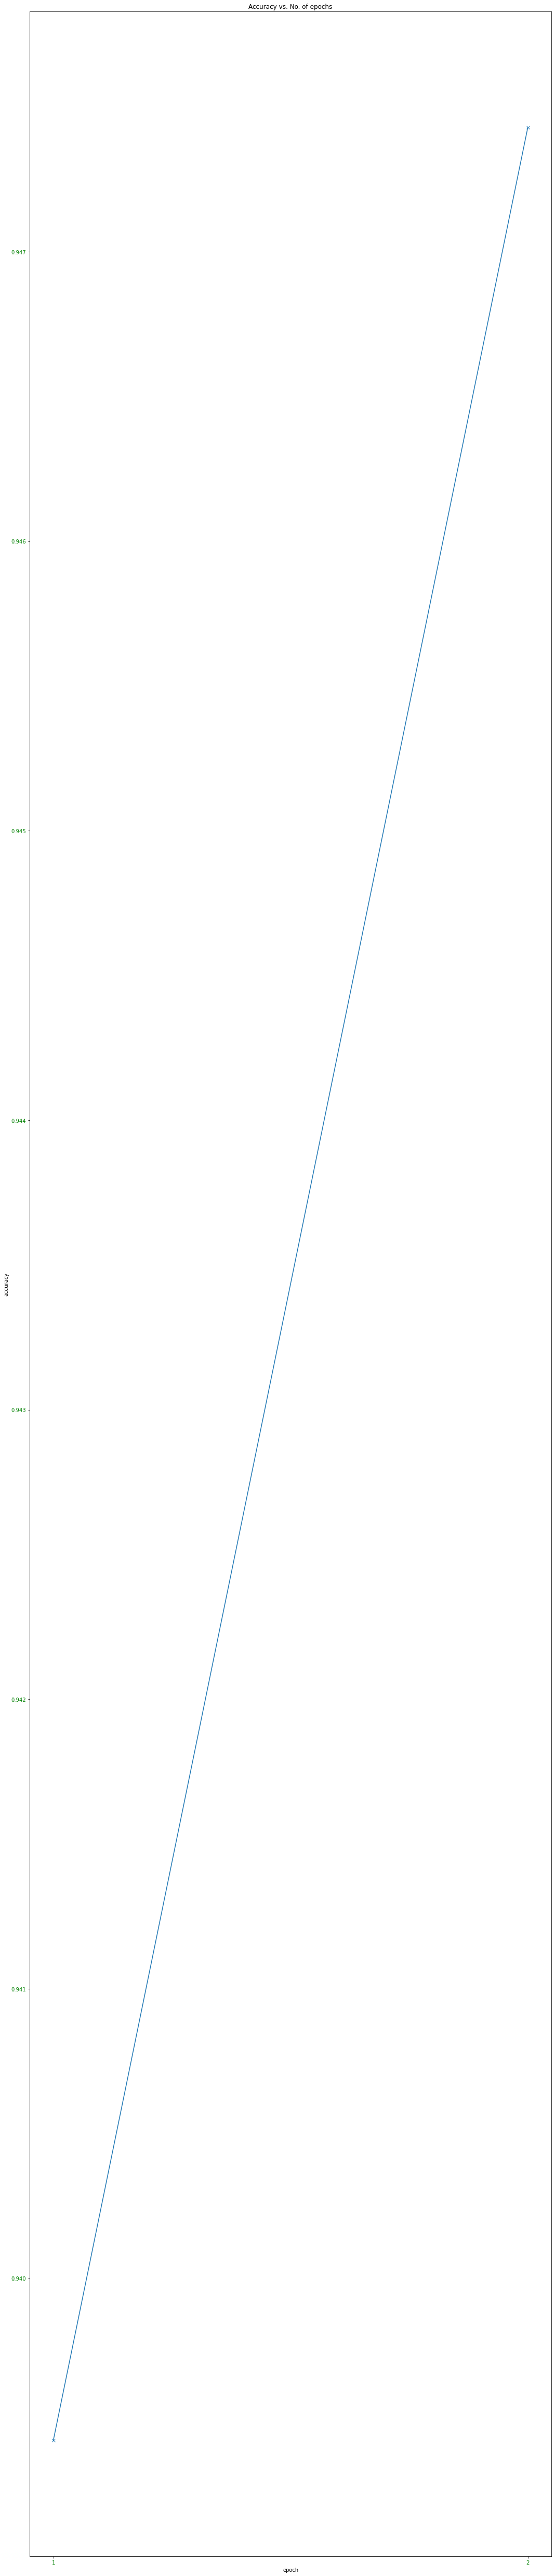

In [84]:
plot_accuracies(num_epochs, val_metrics)

In [85]:
def plot_losses(epoch, train_losses, val_losses):
    #train_losses = [x.get('train_losses') for x in history]
    #val_losses = [x['val_losses'] for x in history]
    x = np.arange(1, epoch+1, 1)
    
    plt.plot(x, train_losses, '-bx')
    plt.plot(x, val_losses, '-rx')
    
    plt.tick_params(labelcolor='g')
    plt.xticks(np.linspace(1, epoch, epoch))
    
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')

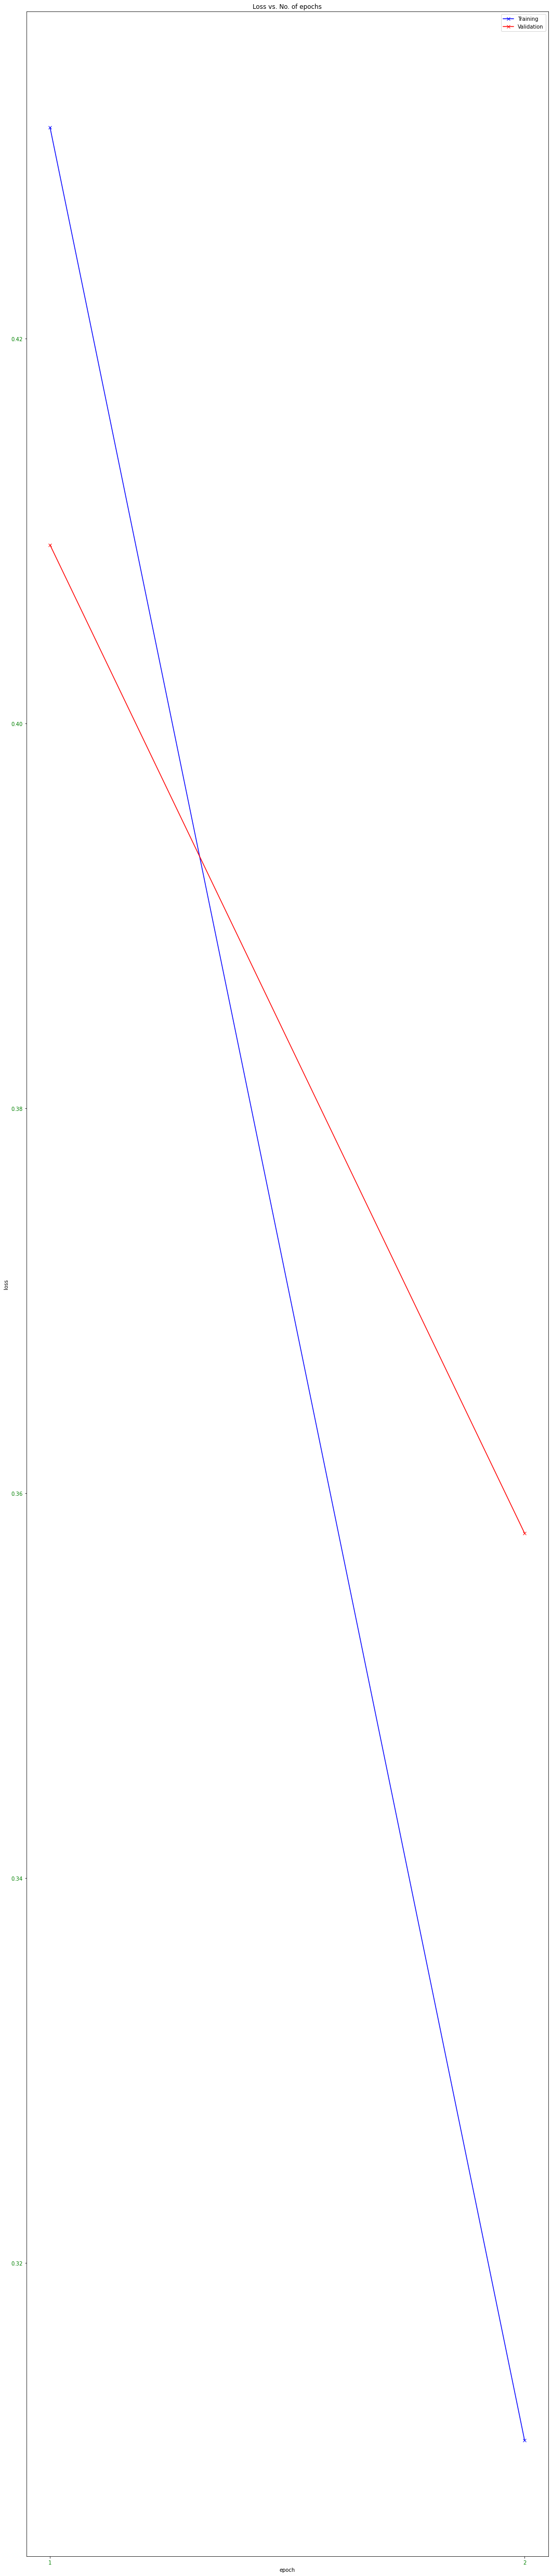

In [86]:
plot_losses(num_epochs, train_losses, val_losses)

In [87]:
result = evaluate(model, loss_Function, test_dl, accuracy)
result

(0.35445379301566926, 582265, 0.9478965763011687)

In [88]:
# checkpoint = torch.load("Checkpoints/model_date_2.pt")
# model.load_state_dict(checkpoint['model_state_dict'])
# epoch = checkpoint['epoch']
# acc = checkpoint['acc']

In [89]:
torch.save(model.state_dict(), 'model_26.pth')

### Load the saved model

In [64]:
# loaded_model = ResNet50(85742)
# to_device(loaded_model, device)

In [65]:
# loaded_model.load_state_dict(torch.load("training/el_13-02.pth"))

In [66]:
# loaded_model.eval()

In [67]:
# val_loss2, _, val_acc2 = evaluate(loaded_model, loss_Function, val_dl, metric=accuracy) #metric=None

In [68]:
# print('Loss: {:.4f}, Accuracy: {:.4f}'.format(val_loss2, val_acc2))
# #print('Loss: {:.4f}'.format(val_loss))

In [69]:
# result2 = evaluate(loaded_model, loss_Function, test_dl, accuracy)
# result2

### Step 5) Displaying results

In [70]:
def create_list():
    img_list = []
    #%% 1 ~ 5908396, or 0~5908395, #85742 identities
    path_imgidx = os.path.join(root_dir1, 'train.idx')
    path_imgrec = os.path.join(root_dir1, 'train.rec')
    imgrec = recordio.MXIndexedRecordIO(path_imgidx, path_imgrec, 'r')
    
    for i in range(5822653):
        header, s = recordio.unpack(imgrec.read_idx(i+1))
        img_list.append(header.label)
        
    lst = np.array(img_list)
    
    return imgrec, lst

In [71]:
imgrec, lst = create_list()
len(lst)

5822653

In [72]:
def fetch_pred_image(imgrec, lst, idx):
    idxs = np.where(lst==idx)[0]
    
    header, s = recordio.unpack(imgrec.read_idx(idxs[-1]))
    img = mx.image.imdecode(s).asnumpy()
    
    return img

In [73]:
#Testing
#img_fetch = fetch_pred_image(imgrec, lst, 59062)

In [74]:
#plt.rcParams["figure.figsize"] = (15, 15)

In [75]:
def prepare_plot(image, origTarget, predTarget, size=5):
    plt.rcParams["figure.figsize"] = (15*size/25, 15*size/5)
    rand = np.random.randint(0, 128, size)
    
    for i in range(size):
        img_fetch = fetch_pred_image(imgrec, lst, predTarget[rand[i]])
        plt.subplot(size, 3, 3*i+1)
        plt.imshow(image[rand[i]])
        plt.axis('off')
        plt.title('Actual id: ' + str(origTarget[rand[i]]))
        
        plt.subplot(size, 3, 3*i+2)
        plt.imshow(np.real(img_fetch))
        plt.axis('off')
        plt.title('Predicted id: ' + str(predTarget[rand[i]]))
        
        plt.subplot(size, 3, 3*i+3)
        plt.axis('off')
        if(origTarget[rand[i]] == predTarget[rand[i]]):
            plt.title('MATCHED!', fontsize = 12, color='g')
        else:
            plt.title('MIS-MATCHED!', fontsize = 15, color='r')
    
    plt.show()

In [76]:
def make_predictions(model, dataLoader, size):
    with torch.no_grad():
        #set the model in evaluation mode
        model.eval()
        
        for xb, yb in dataLoader:
            features = model(xb)
            pred = new_logits(features, yb)
            
            softmax = F.softmax(pred, dim=1)
            sum_check = torch.sum(softmax, dim=1)
            #print(sum_check)
            max_value = torch.max(softmax, dim=1)[1]
            ##print("Predicted labels: ", max_value)
            ##print("Actual labels: ", yb)
            
            matches = max_value == yb
            #print(matches)
        
#             print(pred.shape)
#             print(pred[100].shape)
#             print(torch.max(pred[100]))
#             softmax = F.softmax(pred[100], dim=0)
#             max_value = torch.max(softmax)
#             print(max_value)
#             print("Actual label: ", yb[100].item())
#             index = torch.where(softmax == max_value)[0]
#             print("Predicted label: ", index.item())

            invTransform = transforms.Compose(
                [transforms.Normalize(mean=[0., 0., 0.], std=[1/0.5, 1/0.5, 1/0.5]),
                 transforms.Normalize(mean=[-0.5, -0.5, -0.5], std=[1, 1, 1]),
                ])
            xb = invTransform(xb)
    
            xb = xb.cpu().numpy() #Convert the tensor input into a numpy object
            #print(xb.shape)

            xb = np.transpose(xb, (0, 2, 3, 1)) #Shifting the channel into the 3rd dimension       
            #print(xb.shape)

            yb = yb.cpu().numpy() #Convert the tensor input into a numpy object
            #print(yb[0])

            max_value = max_value.cpu().numpy() #Convert the tensor input into a numpy object
            #print(max_value[0])

            prepare_plot(xb, yb, max_value, size)
            
            break

In [77]:
#make_predictions(loaded_model, test_dl, 30)

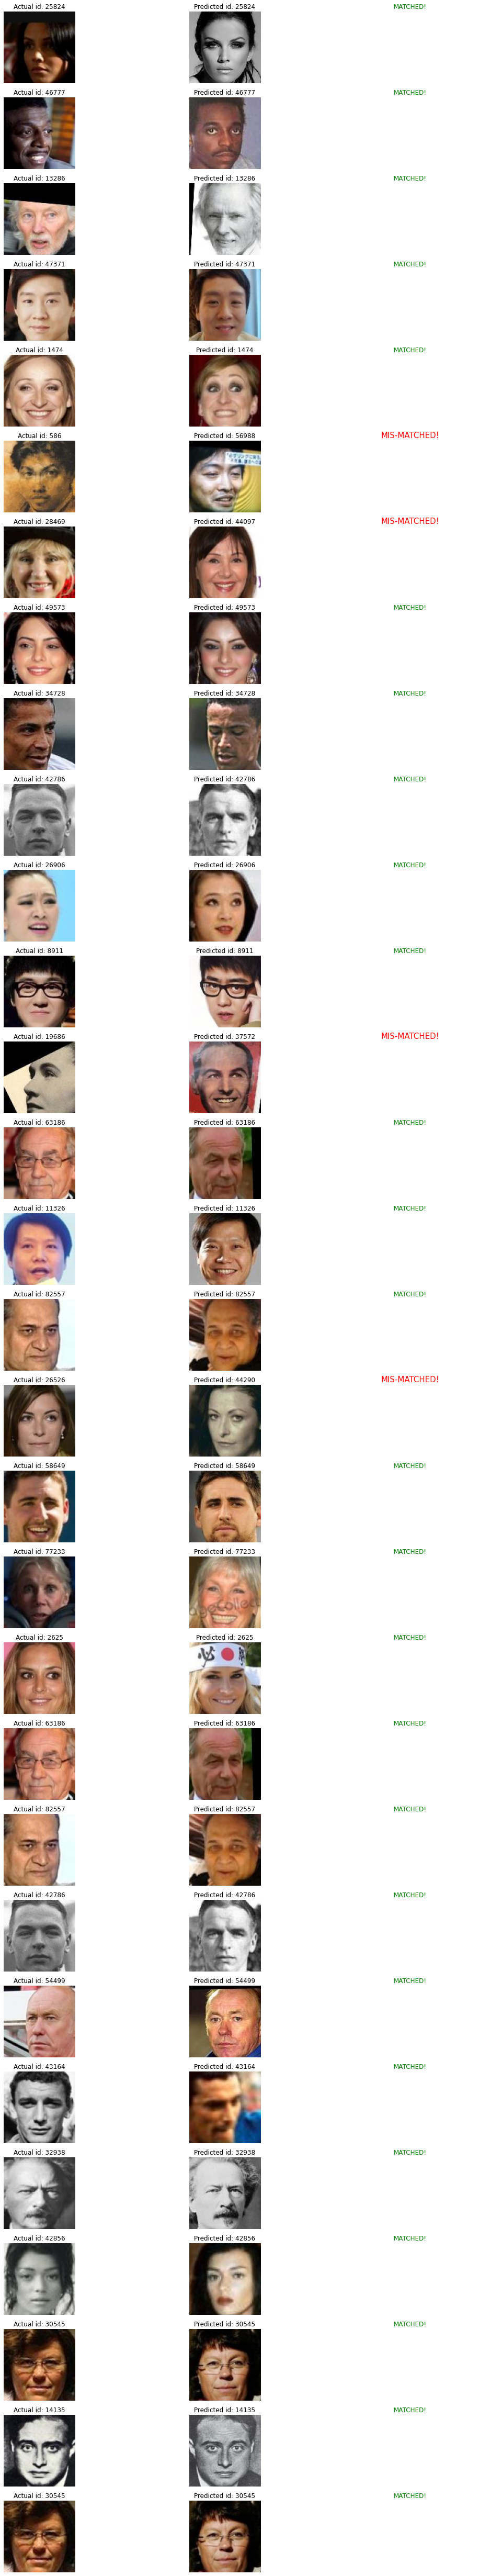

In [90]:
make_predictions(model, test_dl, 30)

In [79]:
# Creating a new data frame
newDataframe = pd.DataFrame()
filename = "model_outputs_26.xlsx"

newDataframe['Train Loss'] = train_losses
newDataframe['Val Loss'] = val_losses
newDataframe['Val Acc.'] = val_metrics

# Converting the data frame to an excel file
newDataframe.to_excel(filename, index = False)

# Reading the data from the outputExcelFile
excelData = pd.read_excel(filename)

#Printing the data frame
print(excelData)

    Train Loss  Val Loss  Val Acc.
0     3.527416  3.657846  0.442767
1     2.327796  2.347985  0.622481
2     1.916217  1.916231  0.689425
3     1.528897  1.867327  0.695396
4     1.208020  1.799803  0.705481
5     1.673244  1.797227  0.706956
6     1.326722  1.876321  0.692563
7     1.250585  1.664572  0.727349
8     1.536389  1.743449  0.712887
9     1.972446  1.572028  0.741717
10    1.329367  1.578054  0.739601
11    1.851978  1.616413  0.733328
12    1.080880  1.519502  0.751582
13    1.544586  1.494110  0.755196
14    1.435644  1.599491  0.737410
15    1.138348  1.588829  0.738420
16    1.803223  1.524794  0.749107
17    1.266944  1.536767  0.748348
18    1.606118  1.622338  0.732924
19    1.741503  1.571054  0.741053
